In [1]:
from typing import Optional, Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.preprocessing import normalize
import seaborn as sns

In [2]:
# plt.xkcd()
plt.rcdefaults()
plt.style.use("ggplot")

In [4]:
non_zero1 = pd.read_csv('data/hg19/matrix.mtx', sep=' ', skiprows=2,
                       names=('gene_id', 'cell_id', 'counts'))
non_zero2 = pd.read_csv('data/processed/sci-CAR_A549/RNA/matrix.mtx', sep=' ', skiprows=2,
                       names=('gene_id', 'cell_id', 'counts'))
shape1 = tuple(non_zero1.iloc[0])[:2][::-1]
shape2 = tuple(non_zero2.iloc[0][:2][::-1])
non_zero1.drop(0, inplace=True)
non_zero2.drop(0, inplace=True)
genes1 = pd.read_csv('data/hg19/genes.tsv', sep='\t', names=('long', 'name'))
genes2 = pd.read_csv('data/processed/sci-CAR_A549/RNA/genes.tsv', sep='\t', names=('name',))

non_zero1.gene_id -= 1
non_zero1.cell_id -= 1
non_zero2.gene_id -= 1
non_zero2.cell_id -= 1

In [5]:
print(shape1, shape2)

(2700, 32738) (6093, 113153)


In [6]:
non_zero2.max()

gene_id    113152
cell_id      6092
counts       2624
dtype: int64

In [7]:
adata1 = sparse.csc_matrix((non_zero1.counts, (non_zero1.cell_id, non_zero1.gene_id)),
                           dtype=np.int16, shape=shape1)

adata2 = sparse.csc_matrix((non_zero2.counts, (non_zero2.cell_id, non_zero2.gene_id)),
                           dtype=np.int16, shape=shape2)

In [63]:
print(adata1.sum(axis=1).mean())
print(adata2.sum(axis=1).mean())

2366.90037037037
3148.678647628426


In [65]:
print(adata1.shape, adata2.shape)

(2700, 32738) (6093, 113153)


In [8]:
adata_norm1 = normalize(adata1, norm='l1', axis=1)
total_count1 = np.array(adata_norm1.sum(axis=0)).flatten()

adata_norm2 = normalize(adata2, norm='l1', axis=1)
total_count2 = np.array(adata_norm2.sum(axis=0)).flatten()

In [9]:
temp_ind1 = np.argpartition(total_count1, -20)[-20:]
ind1 = temp_ind1[np.argsort(total_count1[temp_ind1])]

temp_ind2 = np.argpartition(total_count2, -20)[-20:]
ind2 = temp_ind2[np.argsort(total_count2[temp_ind2])]

In [10]:
ind1

array([11887,  1989, 24087, 32022, 11447, 26912, 19420,   492,  5521,
       18998, 10709, 15745, 24673, 30933, 30970, 26013, 14247, 23794,
       13302, 19154])

In [11]:
ind2

array([ 10835,  47649,  14401,  45349,  41232,  25828,  16560,  41201,
        22790,  47063,  24843,  41474,  27145,  32363,  11053, 113117,
        15863, 107987, 113119,  32365])

In [13]:
print(genes1.iloc[ind1, 1].values)
print(genes2.iloc[ind2, 0].values)

['ACTB' 'RPS27' 'RPLP1' 'RPL3' 'RPS12' 'RPL19' 'RPS3' 'RPL11' 'RPL32'
 'FTH1' 'RPS18' 'RPS6' 'RPS2' 'FTL' 'RPL13A' 'RPL13' 'RPL10' 'B2M'
 'TMSB4X' 'MALAT1']
['DCBLD2' 'PTPRM' 'MAML3' 'ALDH3A1' 'ANXA2' 'ASAP1' 'EFNA5' 'MYO1E'
 'NRCAM' 'LINC00511' 'ASPH' 'THSD4' 'ALDH1A1' 'NEAT1' 'ZBTB20' 'mt-Rnr1'
 'PDE4D' 'Malat1' 'mt-Rnr2' 'MALAT1']


(0.0, 10.0)

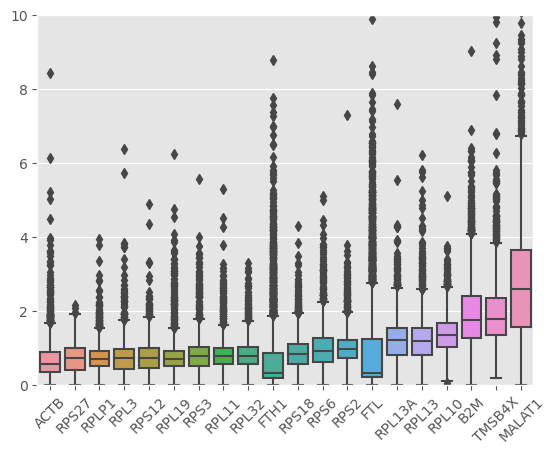

In [19]:
g = sns.boxplot(data=adata_norm1[:,ind1].toarray() * 100)
g.set_xticklabels(genes1.iloc[ind1, 1], rotation=45)
plt.ylim(0, 10)

(0.0, 10.0)

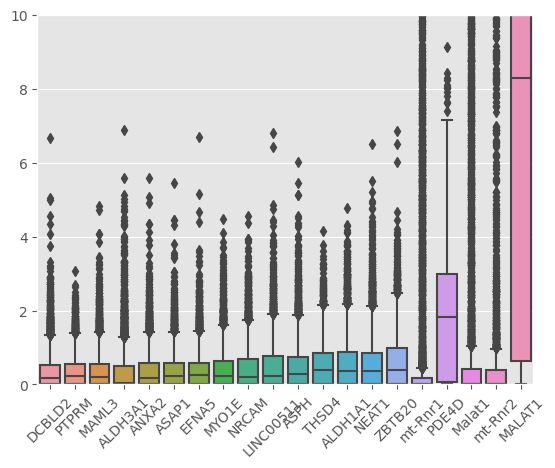

In [66]:
g = sns.boxplot(data=adata_norm2[:,ind2].toarray() * 100 * 113000 / 33000)
g.set_xticklabels(genes2.iloc[ind2, 0], rotation=45)
plt.ylim(0, 10)

In [30]:
def draw_four_plots(adata, genes, capital, df=None):
    if df is None:
        df = pd.DataFrame.sparse.from_spmatrix(adata, columns=genes.name)
    
    cell_filter = (df != 0).sum(axis=1) >= 200
    gene_filter = (df != 0).sum(axis=0) >= 3
    df_filtered = df.loc[cell_filter, gene_filter]
    
    prefix = 'MT-' if capital else 'mt-'
    mt_filter = df_filtered.columns.str.startswith(prefix)
    
    gene_num_per_cell = (df_filtered != 0).sum(axis=1)
    gene_counts_per_cell = df_filtered.sum(axis=1)
    mt_pct = df_filtered.loc[:, mt_filter].sum(axis=1) / gene_counts_per_cell * 100
    
    g = sns.violinplot(data=gene_num_per_cell)
    g = sns.stripplot(data=gene_num_per_cell, jitter=0.4, size=2, color='.3')
    g.set_title('gene_num_per_cell')
    g.set_xticklabels(labels=[])
    plt.show()
    
    g = sns.violinplot(data=gene_counts_per_cell)
    g = sns.stripplot(data=gene_counts_per_cell, jitter=0.4, size=2, color='.3')
    g.set_title('gene_counts_per_cell')
    g.set_xticklabels(labels=[])
    plt.show()
    
    g = sns.violinplot(data=mt_pct)
    g = sns.stripplot(data=mt_pct, jitter=0.4, size=2, color='.3')
    g.set_title('pct_counts_mt')
    g.set_xticklabels(labels=[])
    plt.show()
    
    temp_data = pd.DataFrame({'gene_counts_per_cell':gene_counts_per_cell,
                              'mt_pct':mt_pct, 
                              'gene_num_per_cell':gene_num_per_cell})
    
    sns.scatterplot(data=temp_data, x='gene_counts_per_cell', y='mt_pct', s=7, alpha=0.5)
    plt.show()
    
    sns.scatterplot(data=temp_data, x='gene_counts_per_cell', y='gene_num_per_cell', s=7, alpha=0.5)
    plt.show()
    
    df_filtered_filtered = df_filtered.loc[(gene_num_per_cell < 2500) & (mt_pct < 5)]
    
    return temp_data, df_filtered_filtered

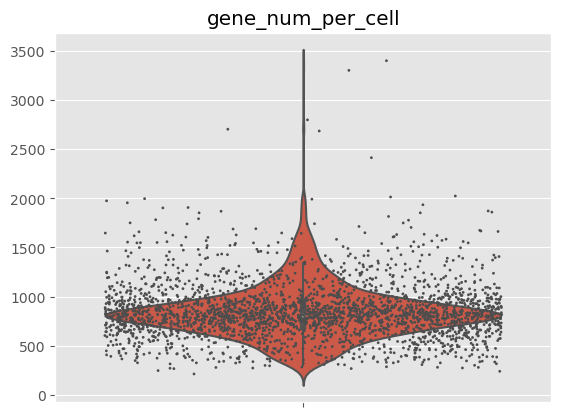

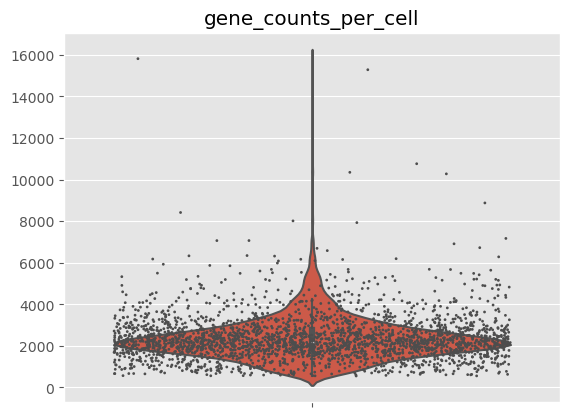

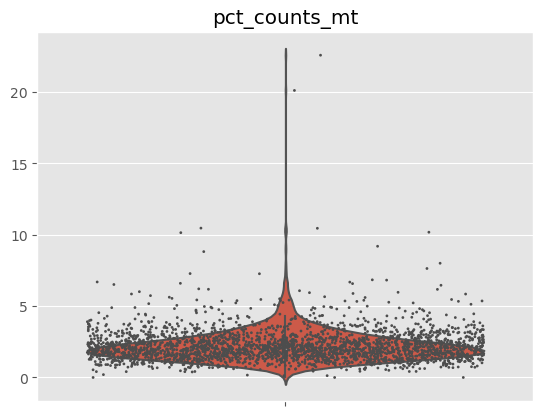

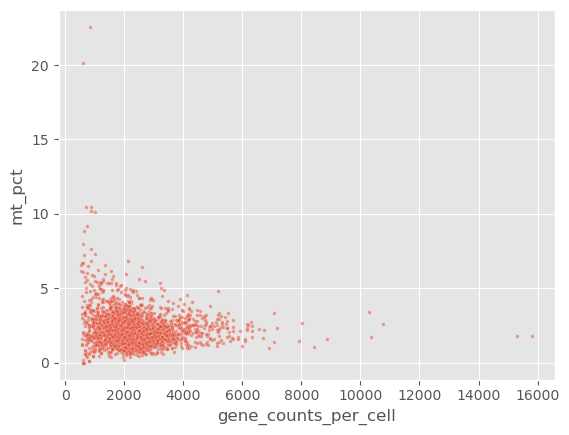

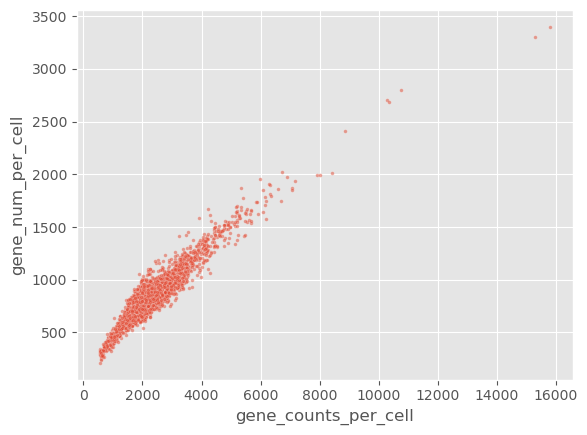

In [33]:
temp_data1, df_filtered_filtered1 = draw_four_plots(adata1, genes1, capital=True)

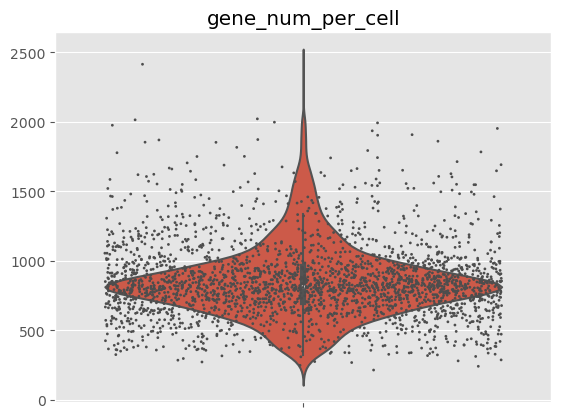

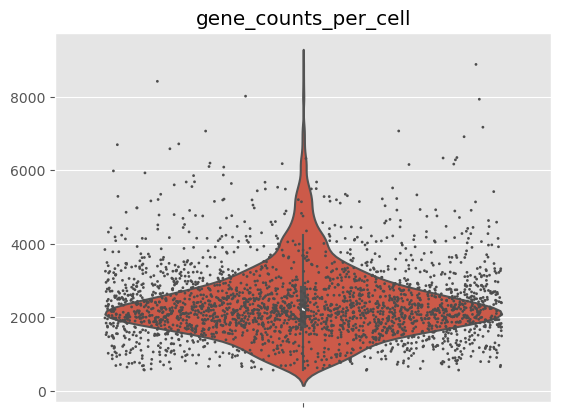

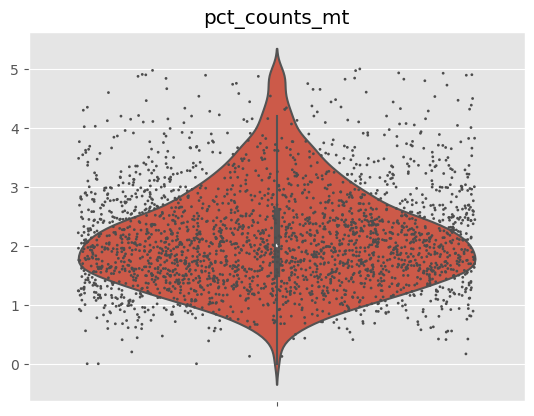

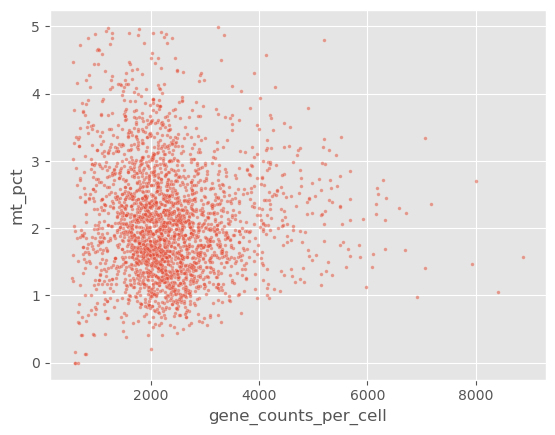

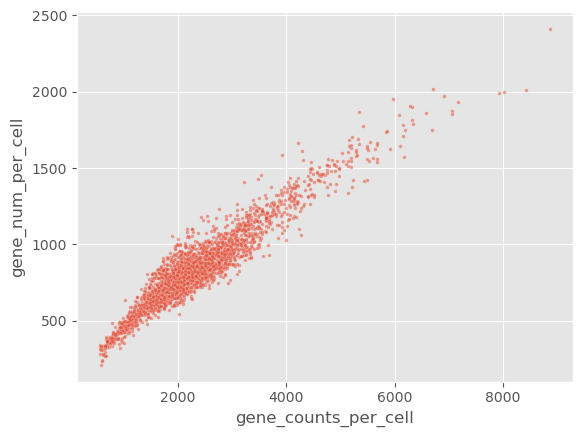

(      gene_counts_per_cell    mt_pct  gene_num_per_cell
 0                     2419  3.017776                779
 1                     4903  3.793596               1352
 2                     3147  0.889736               1129
 3                     2639  1.743085                960
 4                      980  1.224490                521
 ...                    ...       ...                ...
 2695                  3459  2.110437               1153
 2696                  3442  0.929692               1223
 2697                  1684  2.197150                622
 2698                  1022  2.054795                452
 2699                  1984  0.806452                723
 
 [2638 rows x 3 columns],
 name  AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  LINC00115  NOC2L  \
 0              0           0              0              0          0      0   
 1              0           0              0              0          0      0   
 2              0           0              0 

In [35]:
draw_four_plots(None, None, capital=True, df=df_filtered_filtered1)

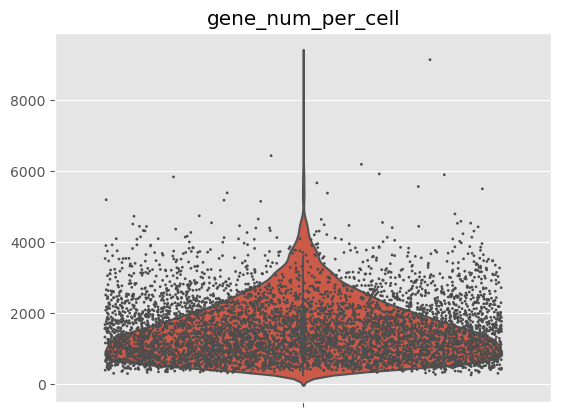

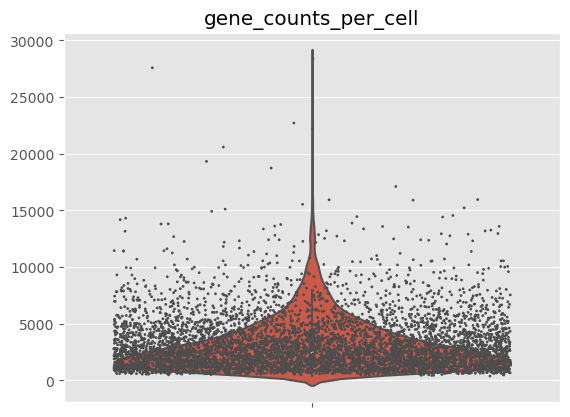

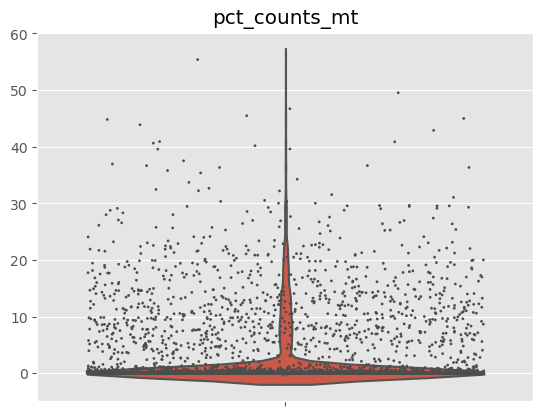

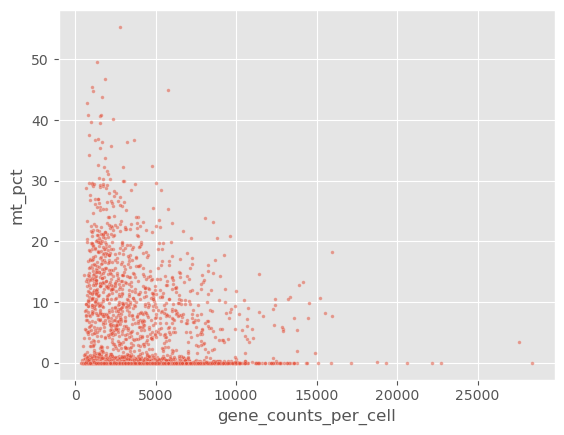

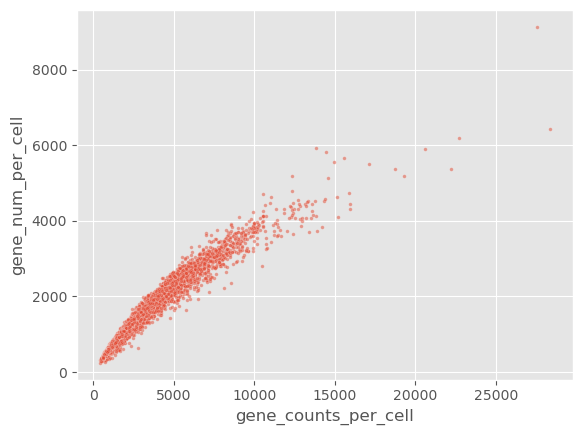

In [36]:
temp_data2, df_filtered_filtered2 = draw_four_plots(adata2, genes2, capital=False)

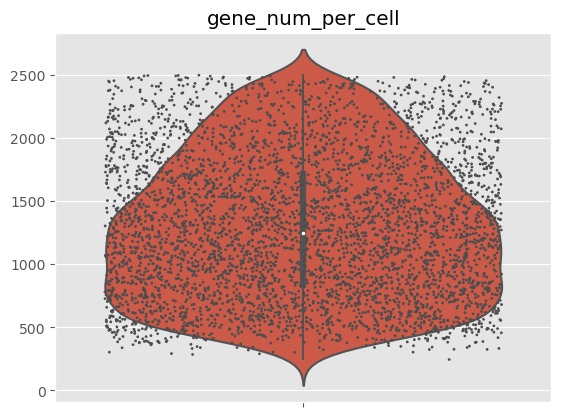

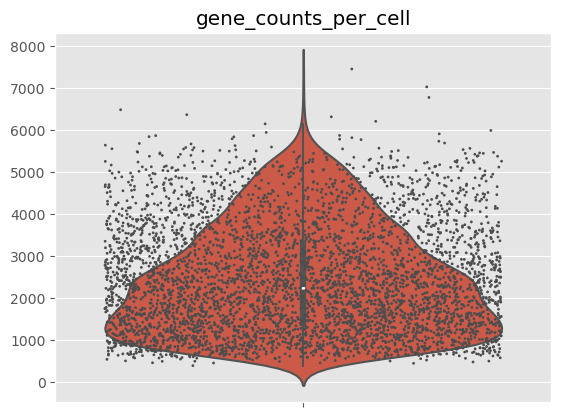

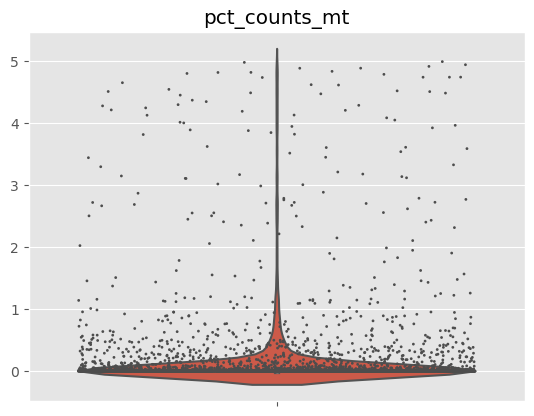

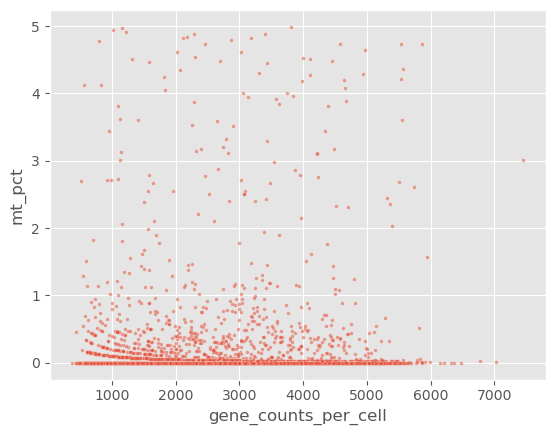

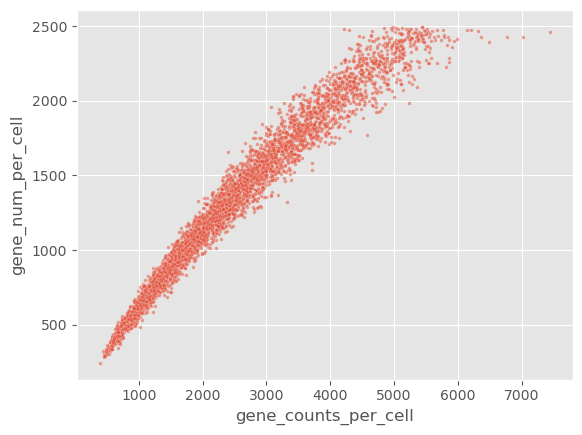

(      gene_counts_per_cell    mt_pct  gene_num_per_cell
 0                     4366  0.137426               2269
 1                     1818  0.000000               1071
 3                     3783  0.000000               2006
 4                     2584  0.000000               1437
 5                     2078  0.000000               1161
 ...                    ...       ...                ...
 6088                  3094  0.000000               1528
 6089                  3296  0.030340               1698
 6090                  4747  0.000000               2228
 6091                  3962  0.000000               1932
 6092                   919  0.000000                566
 
 [4592 rows x 3 columns],
 name  WASH7P  RP11-34P13.7  AL627309.1  RP11-34P13.15  AP006222.2  \
 0          0             0           0              0           0   
 1          0             0           0              0           0   
 3          0             0           0              0           0   
 4      

In [37]:
draw_four_plots(None, None, capital=False, df=df_filtered_filtered2)

In [38]:
adata_filtered_filtered1 = sparse.csr_matrix(df_filtered_filtered1)
adata_filtered_filtered2 = sparse.csr_matrix(df_filtered_filtered2)

In [39]:
adata_filtered_filtered_norm1 = normalize(adata_filtered_filtered1, axis=1, norm='l1') * 1e4
adata_filtered_filtered_norm2 = normalize(adata_filtered_filtered2, axis=1, norm='l1') * 1e4

In [40]:
adata_filtered_filtered_norm_log1p1 = adata_filtered_filtered_norm1.log1p()
adata_filtered_filtered_norm_log1p2 = adata_filtered_filtered_norm2.log1p()

In [41]:
def my_get_mean_var(X, axis=0):
    if isinstance(X, sparse.spmatrix):  # same as sparse.issparse()
        mean, var = my_sparse_mean_variance_axis(X, axis=axis)
        var *= X.shape[axis] / (X.shape[axis] - 1)
    else:
        mean = np.mean(X, axis=axis)
        mean_sq = np.var(X, axis=axis, ddof=1)  # a little overhead (mean counted twice, but it's ok.)
    return mean, var
'''
In standard statistical practice, ddof=1 provides an unbiased estimator of the variance
of a hypothetical infinite population. ddof=0 provides a maximum likelihood estimate of
the variance for normally distributed variables.
'''


def my_sparse_mean_variance_axis(mtx: sparse.spmatrix, axis: int):
    if isinstance(mtx, sparse.csr_matrix):
        ax_minor = 1
        shape = mtx.shape
    elif isinstance(mtx, sparse.csc_matrix):
        ax_minor = 0
        shape = mtx.shape[::-1]
    else:
        raise ValueError('This function only works on sparse csr and csc matrices')
    if axis == ax_minor:
        return my_sparse_mean_var_major_axis(
            mtx.data, mtx.indices, mtx.indptr, *shape, np.float64
        )
    else:
        return my_sparse_mean_var_minor_axis(
            mtx.data, mtx.indices, *shape, np.float64
        )
    

def my_sparse_mean_var_major_axis(
    data,
    indices,
    indptr,
    major_len,
    minor_len,
    dtype
):
    print(0)
    means = np.zeros(major_len, dtype=dtype)
    variances = np.zeros_like(means, dtype=dtype)  # why use zeros_like?
    for ind, (startptr, endptr) in enumerate(zip(indptr[:-1], indptr[1:])):
        counts = endptr - startptr
        
        mean = sum(data[startptr:endptr]) / minor_len
        variance = (sum((i-means[i]) ** 2 for i in data[startptr:endptr]) + mean ** 2 * (minor_len - counts)) / minor_len
        means[ind] = mean
        variances[ind] = variance
        
    return means, variances


def my_sparse_mean_var_minor_axis(
    data,
    indices,
    major_len,
    minor_len,
    dtype
):
    print(1)
    non_zero = indices.shape[0] # same as len(indices)?

    means = np.zeros(minor_len, dtype=dtype)
    variances = np.zeros_like(means, dtype=dtype)

    counts = np.zeros(minor_len, dtype=np.int64)
    
    for ind, num in zip(indices, data):
        means[ind] += num
    
    means /= major_len
    
    for ind, num in zip(indices, data):
        variances[ind] += (num - means[ind]) ** 2
        counts[ind] += 1
        
    variances += [mean ** 2 * (major_len - count) for mean, count in zip(means, counts)]
    variances /= major_len
    
    return means, variances

In [55]:
def highly_variable_genes_single_batch_seurat(
    adata,  # log transformed, base e 
    layer=None,
    min_disp=0.5,
    max_disp=np.inf,
    min_mean=0.0125,
    max_mean=3,
    n_top_genes=None,
    n_bins=20,
    flavor='seurat'
):
    X = adata.layers[layer] if layer is not None else adata#.X
    
    if flavor == 'seurat':
        # 如果不是以e为底的先变成以e为底
        X = np.expm1(X)
        # 然后还原
        
    mean, var = my_get_mean_var(X)
    mean[mean == 0] = 1e-12
    dispersion = var / mean
#     print(any(dispersion < 0))
    if flavor == 'seurat':
        dispersion[dispersion == 0] = np.nan
        dispersion = np.log(dispersion)
        mean = np.log1p(mean)
    df = pd.DataFrame()
    df['dispersions'] = dispersion
    df['means'] = mean
    df['vars'] = var
    
    if flavor == 'seurat':
        df['mean_bin'] = pd.cut(df['means'], bins=n_bins)
        disp_grouped = df.groupby('mean_bin')['dispersions']
        
        single_bin_gene = []
        def find_nan_interval(x):
            if len(x) == 1:
                single_bin_gene.extend(x.index)
                std, mean = x.mean(), 0
            else:
                mean = x.mean()
                std = x.std(ddof=1)
            return (x - mean) / std
        
        df['dispersions_norm'] = disp_grouped.transform(lambda x: find_nan_interval(x))
        if len(single_bin_gene) > 0:
            print(
                f'Gene indices {single_bin_gene} fell into a single bin: their '
                'normalized dispersion was set to 1.\n    '
                'Decreasing `n_bins` will likely avoid this effect.'
            )
    
    dispersion_norm = df['dispersions_norm'].values.astype('float32')
    if n_top_genes is not None:
        dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
        dispersion_norm[
            ::-1
        ].sort()  # interestingly, np.argpartition is slightly slower
        if n_top_genes > adata.shape[1]:
            print(f'`n_top_genes` > `adata.n_var`, returning all genes.')
            n_top_genes = adata.shape[1]
        disp_cut_off = dispersion_norm[n_top_genes - 1]
        gene_subset = np.nan_to_num(df['dispersions_norm'].values) >= disp_cut_off
        logg.debug(
            f'the {n_top_genes} top genes correspond to a '
            f'normalized dispersion cutoff of {disp_cut_off}'
        )
    else:
        dispersion_norm[np.isnan(dispersion_norm)] = 0  # similar to Seurat
        gene_subset = np.logical_and.reduce(
            (
                mean > min_mean,
                mean < max_mean,
                dispersion_norm > min_disp,
                dispersion_norm < max_disp,
            )
        )

    df['highly_variable'] = gene_subset
    return df

In [56]:
def highly_variable_genes(
    adata,
    layer: Optional[str] = None,
    n_top_genes: Optional[int] = None,
    min_disp: Optional[float] = 0.5,
    max_disp: Optional[float] = np.inf,
    min_mean: Optional[float] = 0.0125,
    max_mean: Optional[float] = 3,
    span: Optional[float] = 0.3,
    n_bins: int = 20,
    flavor: Literal['seurat', 'cell_ranger', 'seurat_v3'] = 'seurat',
    subset: bool = False,
    inplace: bool = True,
    batch_key: Optional[str] = None,
) -> Optional[pd.DataFrame]:
    if n_top_genes is not None and not all(
        m is None for m in [min_disp, max_disp, min_mean, max_mean]
    ):
        print('If you pass `n_top_genes`, all cutoffs are ignored.')
        
    if batch_key is None:
        df = _highly_variable_genes_single_batch(
            adata,
            layer=layer,
            min_disp=min_disp,
            max_disp=max_disp,
            min_mean=min_mean,
            max_mean=max_mean,
            n_top_genes=n_top_genes,
            n_bins=n_bins,
            flavor=flavor,
        )
    logg.info('    finished', time=start)

    if inplace or subset:
        print(
            'added\n'
            '    \'highly_variable\', boolean vector (adata.var)\n'
            '    \'means\', float vector (adata.var)\n'
            '    \'dispersions\', float vector (adata.var)\n'
            '    \'dispersions_norm\', float vector (adata.var)'
        )
        if batch_key is not None:
            adata.var['highly_variable_nbatches'] = df[
                'highly_variable_nbatches'
            ].values
            adata.var['highly_variable_intersection'] = df[
                'highly_variable_intersection'
            ].values
            
        if subset:
            adata._inplace_subset_var(df['highly_variable'].values)
        return df
    else:
        return df

In [57]:
df1 = highly_variable_genes_single_batch_seurat(adata_filtered_filtered_norm_log1p1, min_mean=0.0125, max_mean=3, min_disp=0.5)

1
Gene indices [7854] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.


In [58]:
df1.shape

(13714, 6)

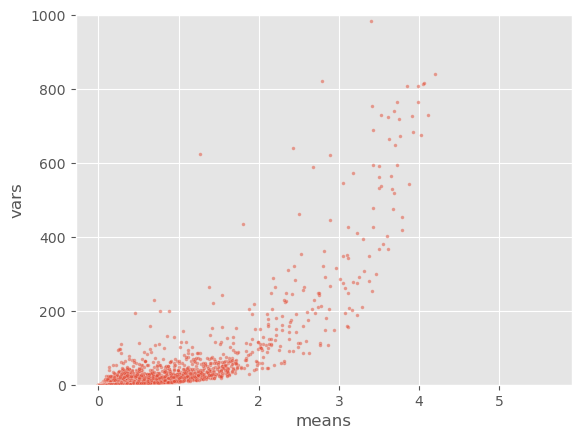

In [70]:
sns.scatterplot(data=df1, x="means", y="vars", s=7, alpha=0.5)
plt.ylim(0, 1000)
plt.show()

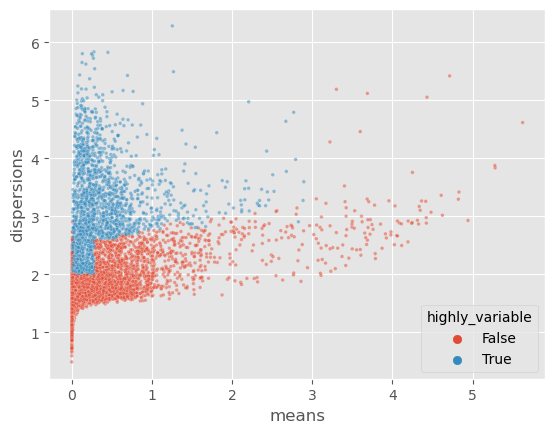

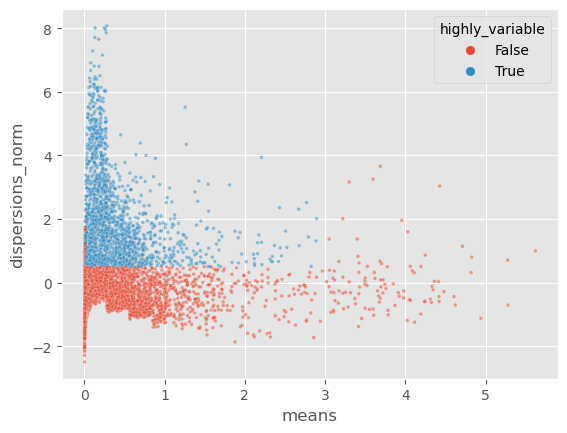

In [53]:
sns.scatterplot(data=df1, x="means", y="dispersions", hue="highly_variable", s=7, alpha=0.5)
plt.show()
sns.scatterplot(data=df1, x="means", y="dispersions_norm", hue="highly_variable", s=7, alpha=0.5)
plt.show()

In [51]:
df2 = highly_variable_genes_single_batch_seurat(adata_filtered_filtered_norm_log1p2, min_mean=0.0125, max_mean=3, min_disp=0.5)
print(df2.shape)

1
Gene indices [8185, 16516] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
(48424, 5)


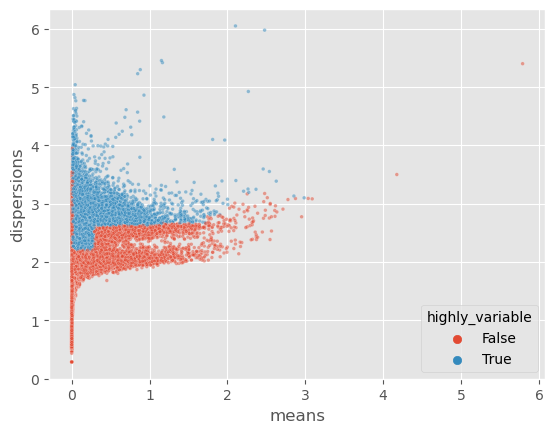

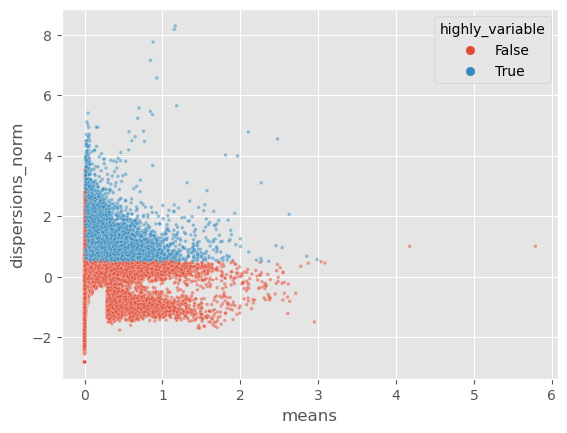

In [54]:
sns.scatterplot(data=df2, x="means", y="dispersions", hue="highly_variable", s=7, alpha=0.5)
plt.show()
sns.scatterplot(data=df2, x="means", y="dispersions_norm", hue="highly_variable", s=7, alpha=0.5)
plt.show()

In [ ]:
b = sparse.csr_matrix((3, 4), dtype=np.int8)

In [ ]:
indptr = np.array([0, 2, 3, 6])
indices = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
b = sparse.csr_matrix((data, indices, indptr), shape=(3, 3))

In [ ]:
len(b.indices)

In [ ]:
sparse.issparse(b)

In [ ]:
sparse.issparse([[0]])

In [ ]:
print(adata_filtered_twice_norm[:,1:10])

In [ ]:
print(np.expm1(adata_filtered_twice_norm_log1plus)[:,1:10])